In [ ]:
!pip install tensorflow

In [ ]:
!pip install sklearn
!pip install seaborn

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from google.colab import files, drive
import zipfile

In [3]:
print("Mounting Google Drive...")
drive.mount('/content/drive')

Mounting Google Drive...
Mounted at /content/drive


In [4]:
!mkdir -p /content/pneumonia_data

In [5]:
print("\nSetting up Kaggle credentials...")
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/ 2>/dev/null || echo "Please upload kaggle.json to your Google Drive"
!chmod 600 ~/.kaggle/kaggle.json


Setting up Kaggle credentials...


In [6]:
print("\nDownloading dataset from Kaggle...")
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content/


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other


In [7]:
print("\nExtracting dataset...")
with zipfile.ZipFile('/content/chest-xray-pneumonia.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/pneumonia_data')
print("\nExtraction Complete!")


Extracting dataset...

Extraction Complete!


In [8]:
data_dir = '/content/pneumonia_data/chest_xray'

print("\nDataset structure:")
!find {data_dir} -type d | sort


Dataset structure:
/content/pneumonia_data/chest_xray
/content/pneumonia_data/chest_xray/chest_xray
/content/pneumonia_data/chest_xray/chest_xray/test
/content/pneumonia_data/chest_xray/chest_xray/test/NORMAL
/content/pneumonia_data/chest_xray/chest_xray/test/PNEUMONIA
/content/pneumonia_data/chest_xray/chest_xray/train
/content/pneumonia_data/chest_xray/chest_xray/train/NORMAL
/content/pneumonia_data/chest_xray/chest_xray/train/PNEUMONIA
/content/pneumonia_data/chest_xray/chest_xray/val
/content/pneumonia_data/chest_xray/chest_xray/val/NORMAL
/content/pneumonia_data/chest_xray/chest_xray/val/PNEUMONIA
/content/pneumonia_data/chest_xray/__MACOSX
/content/pneumonia_data/chest_xray/__MACOSX/chest_xray
/content/pneumonia_data/chest_xray/__MACOSX/chest_xray/test
/content/pneumonia_data/chest_xray/__MACOSX/chest_xray/test/NORMAL
/content/pneumonia_data/chest_xray/__MACOSX/chest_xray/test/PNEUMONIA
/content/pneumonia_data/chest_xray/__MACOSX/chest_xray/train
/content/pneumonia_data/chest_xr

In [9]:
# Count images in each split and category
train_normal = len(os.listdir(os.path.join(data_dir, 'train', 'NORMAL')))
train_pneumonia = len(os.listdir(os.path.join(data_dir, 'train', 'PNEUMONIA')))

val_normal = len(os.listdir(os.path.join(data_dir, 'val', 'NORMAL')))
val_pneumonia = len(os.listdir(os.path.join(data_dir, 'val', 'PNEUMONIA')))

test_normal = len(os.listdir(os.path.join(data_dir, 'test', 'NORMAL')))
test_pneumonia = len(os.listdir(os.path.join(data_dir, 'test', 'PNEUMONIA')))

In [10]:
print("\nTrain set - Normal: {}, Pneumonia: {}, Total: {}".format(
    train_normal, train_pneumonia, train_normal + train_pneumonia))
print("Validation set - Normal: {}, Pneumonia: {}, Total: {}".format(
    val_normal, val_pneumonia, val_normal + val_pneumonia))
print("Test set - Normal: {}, Pneumonia: {}, Total: {}".format(
    test_normal, test_pneumonia, test_normal + test_pneumonia))


Train set - Normal: 1341, Pneumonia: 3875, Total: 5216
Validation set - Normal: 8, Pneumonia: 8, Total: 16
Test set - Normal: 234, Pneumonia: 390, Total: 624


In [11]:
# Check for class imbalance
print("\nClass distribution:")
print(f"Train set ratio (Pneumonia:Normal): {train_pneumonia/train_normal:.2f}:1")
print(f"Validation set ratio (Pneumonia:Normal): {val_pneumonia/val_normal:.2f}:1")
print(f"Test set ratio (Pneumonia:Normal): {test_pneumonia/test_normal:.2f}:1")


Class distribution:
Train set ratio (Pneumonia:Normal): 2.89:1
Validation set ratio (Pneumonia:Normal): 1.00:1
Test set ratio (Pneumonia:Normal): 1.67:1


In [12]:
def display_samples(data_dir, split='train', num_samples=3):
    normal_dir = os.path.join(data_dir, split, 'NORMAL')
    pneumonia_dir = os.path.join(data_dir, split, 'PNEUMONIA')

    normal_files = os.listdir(normal_dir)[:num_samples]
    pneumonia_files = os.listdir(pneumonia_dir)[:num_samples]

    plt.figure(figsize=(15, 8))

    # Display normal samples
    for i, img_file in enumerate(normal_files):
        img_path = os.path.join(normal_dir, img_file)
        img = plt.imread(img_path)
        plt.subplot(2, num_samples, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f'Normal\n{img.shape}')
        plt.axis('off')

    # Display pneumonia samples
    for i, img_file in enumerate(pneumonia_files):
        img_path = os.path.join(pneumonia_dir, img_file)
        img = plt.imread(img_path)
        plt.subplot(2, num_samples, i+num_samples+1)
        plt.imshow(img, cmap='gray')
        plt.title(f'Pneumonia\n{img.shape}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


Displaying sample images from training set:


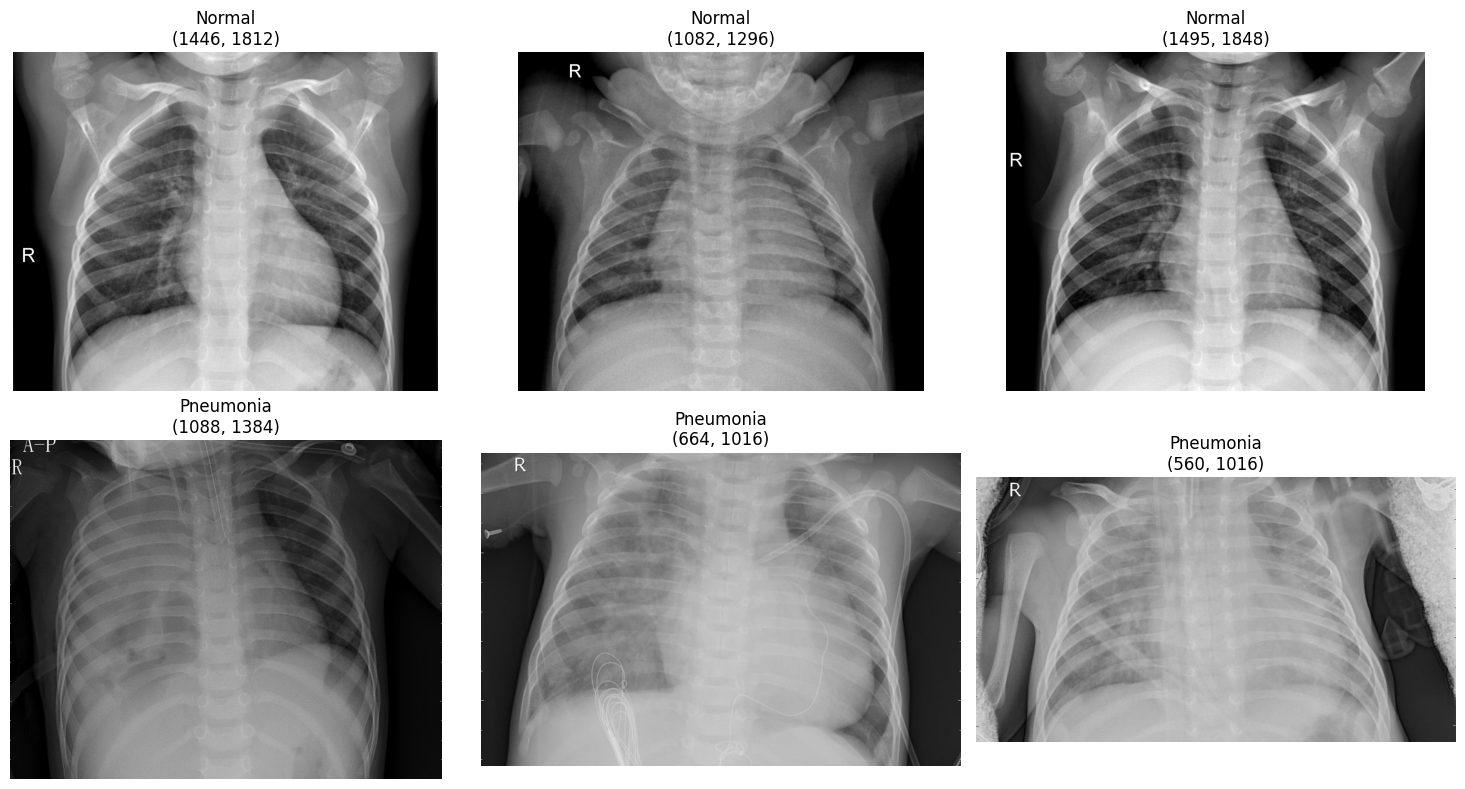

In [13]:
print("\nDisplaying sample images from training set:")
display_samples(data_dir, 'train')

In [14]:
img_height = 512
img_width = 512
batch_size = 32

In [15]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1  # Use 20% of training data for validation
)

train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True,
    color_mode='grayscale'
)

validation_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=True,
    color_mode='grayscale'
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")

Found 4695 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Training samples: 4695
Validation samples: 521



Displaying augmented training images:


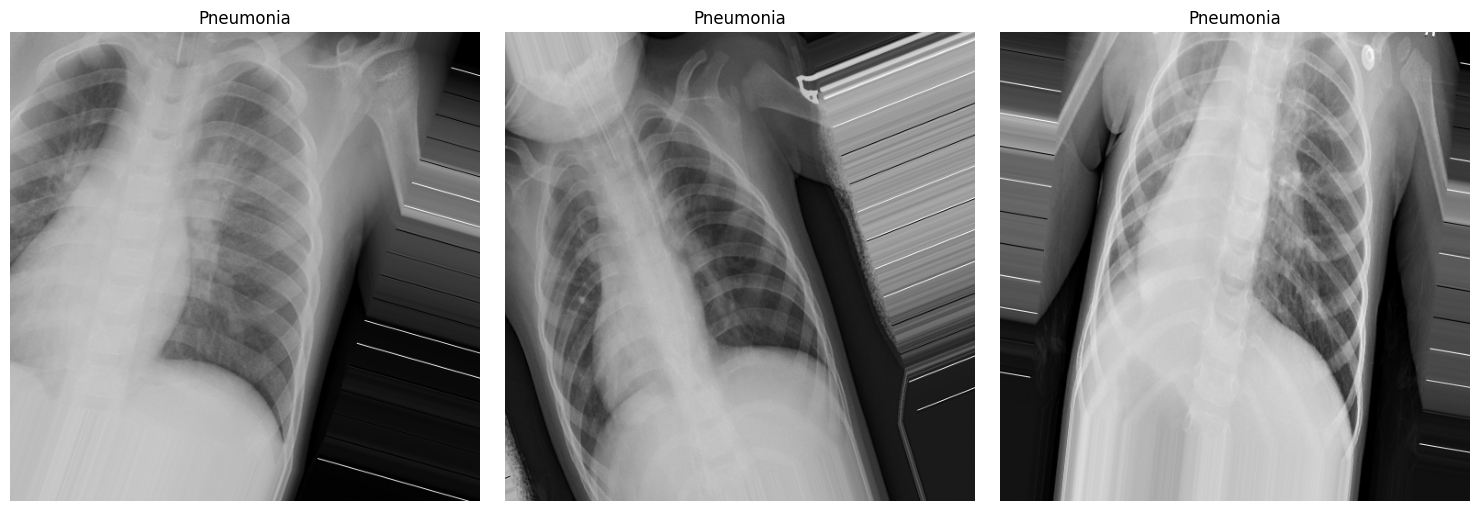

In [16]:
def display_augmented_images(generator, num_images=3):
    # Get a batch from the generator
    x_batch, y_batch = next(generator)

    plt.figure(figsize=(15, 5))
    for i in range(min(num_images, len(x_batch))):
        plt.subplot(1, num_images, i+1)
        # For grayscale images, we need to squeeze the channel dimension
        plt.imshow(x_batch[i].squeeze(), cmap='gray')
        plt.title('Normal' if y_batch[i] == 0 else 'Pneumonia')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("\nDisplaying augmented training images:")
display_augmented_images(train_generator)

In [17]:
def create_transfer_learning_model():
    # Most pre-trained models expect 3 channels, so we need to adapt for grayscale

    # Create a preprocessing layer to convert 1 channel to 3 channels
    inputs = layers.Input(shape=(img_height, img_width, 1))
    # Repeat the grayscale channel 3 times
    x = layers.Concatenate()([inputs, inputs, inputs])

    # Load pre-trained model without top layers
    base_model = tf.keras.applications.DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=(img_height, img_width, 3)
    )

    # Freeze the base model
    base_model.trainable = False

    # Connect our inputs to the base model
    x = base_model(x)

    # Add classification head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

In [18]:
print("\nInitializing transfer learning model (DenseNet121)...")
model = create_transfer_learning_model()
print("\nInitialization complete!")


Initializing transfer learning model (DenseNet121)...
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

Initialization complete!


In [19]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [20]:
total_train = train_normal + train_pneumonia
class_weight = {
    0: (1 / train_normal) * (total_train / 2.0),  # Normal
    1: (1 / train_pneumonia) * (total_train / 2.0)  # Pneumonia
}
print("\nClass weights to handle imbalance:", class_weight)


Class weights to handle imbalance: {0: 1.9448173005219984, 1: 0.6730322580645162}


In [21]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 512, 512, 3)    │              0 │ input_layer[0][0],     │
│                           │                        │                │ input_layer[0][0],     │
│                           │                        │                │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ densenet121 (Functional)  │ (None, 16, 16, 1024)   │      7,037,504 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 1024)           │              0 │ densenet121[0][0]      │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │        524,800 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         65,664 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │            129 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 7,628,097 (29.10 MB)

 Trainable params: 590,593 (2.25 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [22]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_pneumonia_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

In [23]:
print("\nTraining the model...")
epochs = 30
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=max(1, validation_generator.samples // batch_size),
    callbacks=[early_stopping, reduce_lr, checkpoint],
    class_weight=class_weight
)
print("\nTraining Complete!")


Training the model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


KeyboardInterrupt: 


Plotting training history:


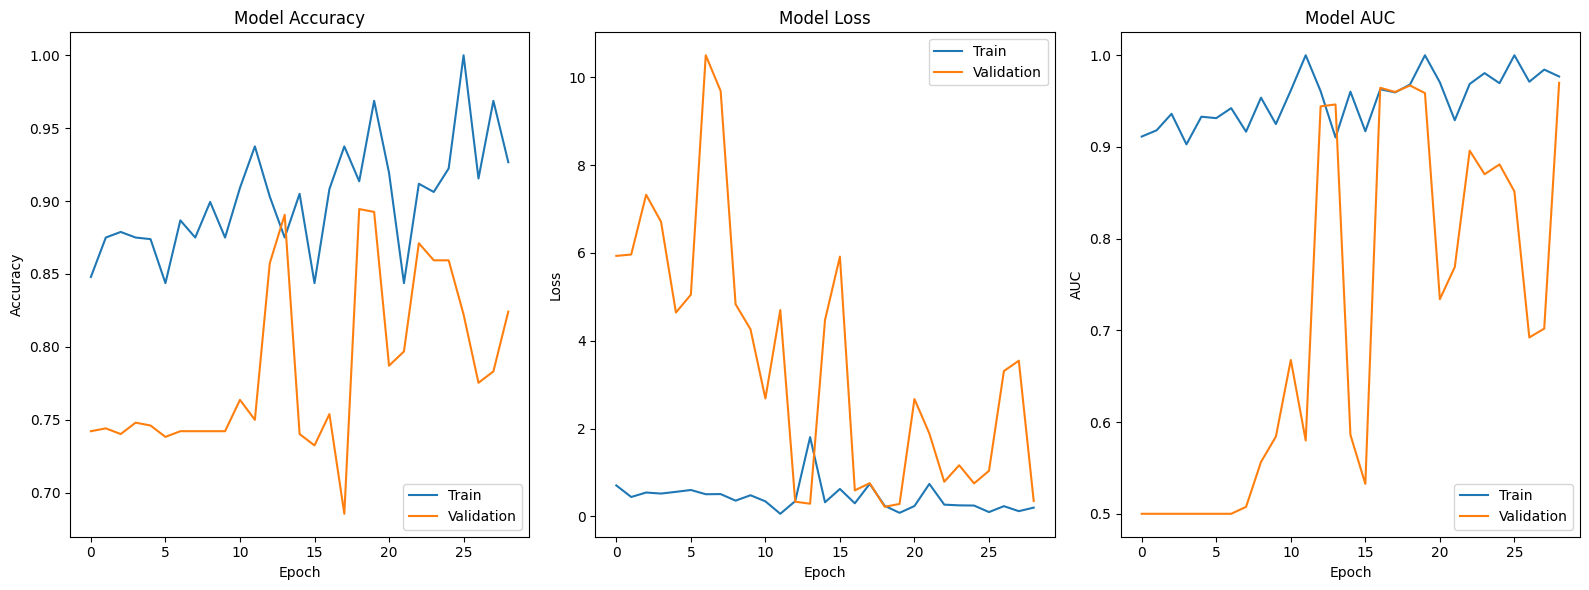

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(16, 6))

    # Plot accuracy
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Plot loss
    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot AUC
    plt.subplot(1, 3, 3)
    plt.plot(history.history['auc'])
    plt.plot(history.history['val_auc'])
    plt.title('Model AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend(['Train', 'Validation'], loc='lower right')

    plt.tight_layout()
    plt.show()

print("\nPlotting training history:")
plot_training_history(history)

In [ ]:
print("\nEvaluating on test set:")
val_test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = val_test_datagen.flow_from_directory(
    os.path.join(data_dir, 'test'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    color_mode='grayscale'
)
test_results = model.evaluate(test_generator, steps=max(1, test_generator.samples // batch_size))
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")
print(f"Test AUC: {test_results[2]:.4f}")
print(f"Test Precision: {test_results[3]:.4f}")
print(f"Test Recall: {test_results[4]:.4f}")


Evaluating on test set:
Found 624 images belonging to 2 classes.
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 249ms/step - accuracy: 0.8494 - auc: 0.5983 - loss: 0.3718 - precision: 0.5211 - recall: 0.4711
Test Loss: 0.4143
Test Accuracy: 0.7796
Test AUC: 0.9162
Test Precision: 0.9138
Test Recall: 0.7086


In [ ]:
test_generator.reset()
steps = int(np.ceil(test_generator.samples / batch_size))
y_pred = model.predict(test_generator, steps=steps)

y_pred_classes = (y_pred > 0.5).astype(int)
y_true = test_generator.classes

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 487ms/step



Confusion Matrix:


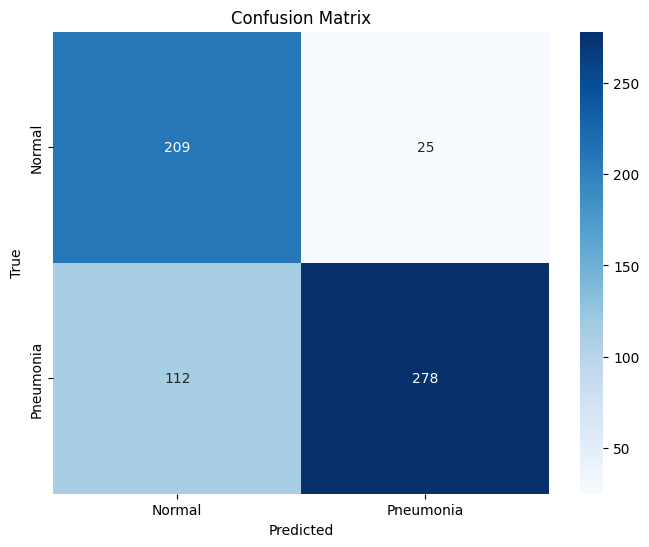

In [ ]:
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes,
                           target_names=['Normal', 'Pneumonia']))


Classification Report:
              precision    recall  f1-score   support

      Normal       0.65      0.89      0.75       234
   Pneumonia       0.92      0.71      0.80       390

    accuracy                           0.78       624
   macro avg       0.78      0.80      0.78       624
weighted avg       0.82      0.78      0.78       624




Visualizing model predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


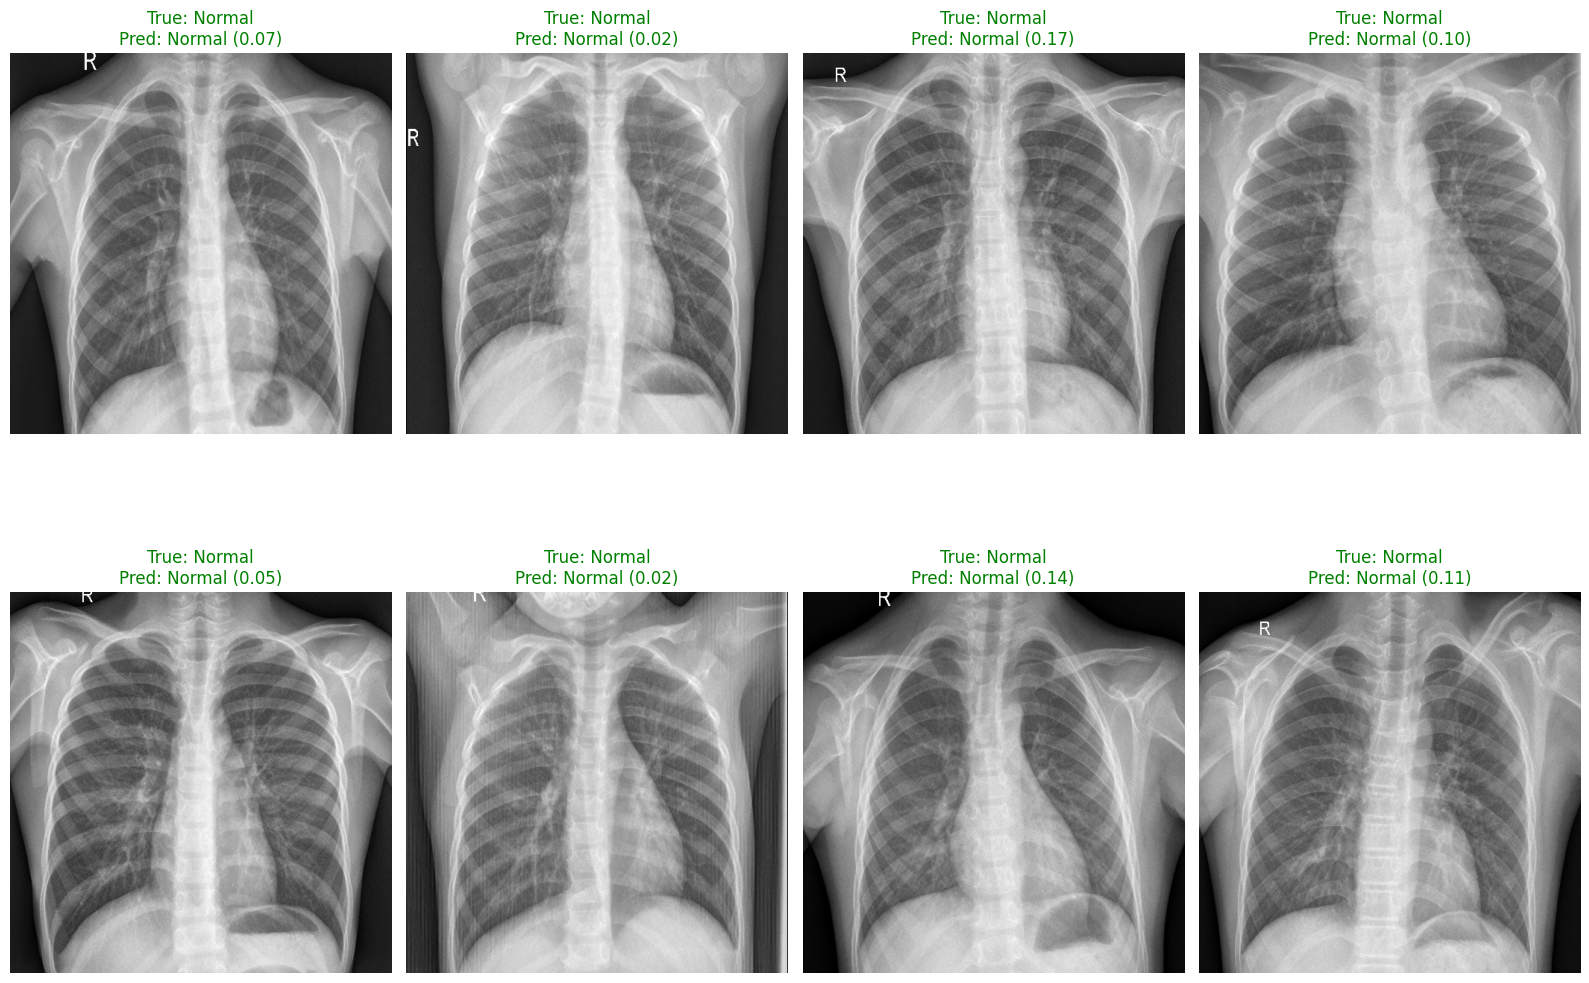

In [ ]:
def visualize_predictions(model, test_generator, num_samples=8):
    # Reset generator
    test_generator.reset()

    # Get a batch of images and their true labels
    images, true_labels = next(test_generator)

    # Make predictions
    predictions = model.predict(images)
    pred_labels = (predictions > 0.5).astype(int).flatten()

    # Convert true labels to integers if they're not already
    true_labels = true_labels.astype(int)

    # Display images with predictions
    plt.figure(figsize=(16, 12))
    for i in range(min(num_samples, len(images))):
        plt.subplot(2, 4, i+1)
        plt.imshow(images[i].squeeze(), cmap='gray')

        # Get class names
        true_class = 'Normal' if true_labels[i] == 0 else 'Pneumonia'
        pred_class = 'Normal' if pred_labels[i] == 0 else 'Pneumonia'

        color = 'green' if true_labels[i] == pred_labels[i] else 'red'
        title = f"True: {true_class}\nPred: {pred_class} ({predictions[i][0]:.2f})"
        plt.title(title, color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

print("\nVisualizing model predictions:")
visualize_predictions(model, test_generator)

In [ ]:
print("\nFine-tuning the model by unfreezing some layers...")

    # Unfreeze some layers for fine-tuning
    base_model = model.layers[2]  # DenseNet121 is the third layer in our model

    # Unfreeze the last dense block of DenseNet
    # DenseNet121 has 4 dense blocks, we'll unfreeze the last one
    for layer in base_model.layers:
        if 'conv5' in layer.name or 'bn5' in layer.name:
            layer.trainable = True

    # Recompile the model with a lower learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Use a lower learning rate for fine-tuning
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    # Train for a few more epochs
    fine_tune_epochs = 10
    history_fine_tune = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=fine_tune_epochs,
        validation_data=validation_generator,
        validation_steps=max(1, validation_generator.samples // batch_size),
        callbacks=[early_stopping, reduce_lr, checkpoint],
        class_weight=class_weight
    )

    # Evaluate fine-tuned model
    print("\nEvaluating fine-tuned model on test set:")
    test_results = model.evaluate(test_generator, steps=max(1, test_generator.samples // batch_size))
    print(f"Test Loss: {test_results[0]:.4f}")
    print(f"Test Accuracy: {test_results[1]:.4f}")
    print(f"Test AUC: {test_results[2]:.4f}")
    print(f"Test Precision: {test_results[3]:.4f}")
    print(f"Test Recall: {test_results[4]:.4f}")

In [ ]:
model.save('/content/drive/MyDrive/pneumonia_classifier_transfer_learning.h5')
print("\nModel saved to Google Drive as 'pneumonia_classifier_transfer_learning.h5'")


Model saved to Google Drive as 'pneumonia_classifier.h5'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


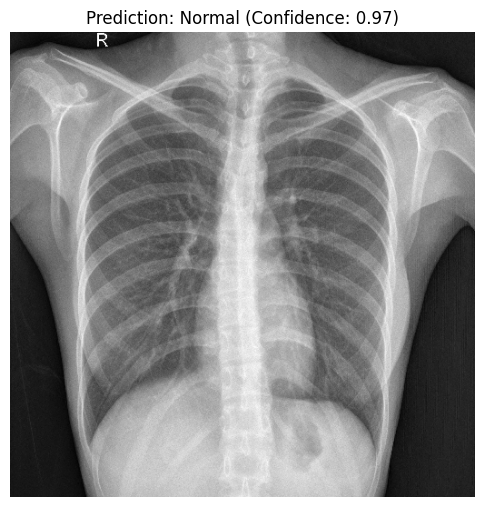

('Normal', np.float32(0.96901137))

In [ ]:
def predict_xray(model, image_path):
    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=(img_height, img_width), color_mode='grayscale'
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    prediction = model.predict(img_array)
    predicted_class = 'Pneumonia' if prediction > 0.5 else 'Normal'
    confidence = prediction[0][0] if prediction > 0.5 else 1 - prediction[0][0]

    plt.figure(figsize=(6, 8))
    plt.imshow(img, cmap='gray')
    plt.title(f"Prediction: {predicted_class} (Confidence: {confidence:.2f})")
    plt.axis('off')
    plt.show()

    return predicted_class, confidence

sample_img_path = '/content/pneumonia_data/chest_xray/test/NORMAL/IM-0035-0001.jpeg'
predict_xray(model, sample_img_path)

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):

    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron with respect to
    # the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.maximum(tf.reduce_max(heatmap), 1e-10)
    return heatmap.numpy()

def display_gradcam(image_path, heatmap, alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_height, img_width))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0

    # Resize the heatmap to match the image size
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = plt.cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Display the result
    plt.figure(figsize=(10, 8))
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

last_conv_layer_name = None
for layer in reversed(base_model.layers):
    if isinstance(layer, layers.Conv2D):
        last_conv_layer_name = layer.name
        break

print(f"\nLast convolutional layer for Grad-CAM: {last_conv_layer_name}")

sample_img_path = '/content/pneumonia_data/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg'
img = tf.keras.preprocessing.image.load_img(
    sample_img_path, target_size=(img_height, img_width), color_mode='grayscale'
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
display_gradcam(sample_img_path, heatmap)